In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Work-flow with decision trees

**Step 1.** Load data for classification.

In this first example we would use only two features of `iris` dataset to perform further visualization.

In [2]:
from sklearn.datasets import load_iris
data = load_iris()

In [3]:
n_features = 2
df = pd.DataFrame(
    data = np.hstack((data.data[:, :n_features], data.target[:, np.newaxis])),
    columns = np.hstack((data.feature_names[:n_features], ['target']))
)
df.head()

,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0.0
1,4.9,3.0,0.0
2,4.7,3.2,0.0
3,4.6,3.1,0.0
4,5.0,3.6,0.0


**Step 2.** Check on `np.nan` values.

Result: there is no need to fill `np.nan` values.

In [4]:
df.isna().any(axis=0)

sepal length (cm)    False
sepal width (cm)     False
target               False
dtype: bool

**Step 3.** Check if scaling is necessary

In [5]:
display(df.describe().iloc[1:3, :])

,sepal length (cm),sepal width (cm),target
mean,5.843333,3.057333,1.000000
std,0.828066,0.435866,0.819232


**Result:** the descriptive statistics of features are in different range - so, we would perform scaling

Below we would try `MinMaxScaler` approach.

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
min_max_ranges = [(0., 1.), (0.01, 0.099)]

**Step 4** Create `DecisionTreeClassifier` classifier

Plus we set several tree parameters for further learning. 

P.S. We would talk about parameters below further, because it is very important notes about `DecisionTreeClassifier`.

In [7]:
from sklearn.tree import DecisionTreeClassifier as DTC
clf = DTC(random_state=1)

max_depth_list = np.arange(1, 12, 2)
criterion_list = ['gini', 'entropy']
max_features_list = ['auto', 'sqrt', 'log2']

**Step 5.** Split dataset on train and test.

In [8]:
pd.DataFrame(df.target.value_counts())

,target
2.0,50
1.0,50
0.0,50


In [9]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df.target.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=1, stratify=y
)

**Step 5.** Create pipeline object

Our work-flow would consists from two steps:
1. Scaling with `MinMaxScaler` with different parameters
2. Learning of `DecisionTreeClassifier` with different parameters

In [10]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps = [
        ('scale', scaler),
        ('algo', clf)
    ]
)

**Step 6.** Create `RandomizedSearchCV`

In [11]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scale', 'algo', 'scale__copy', 'scale__feature_range', 'algo__class_weight', 'algo__criterion', 'algo__max_depth', 'algo__max_features', 'algo__max_leaf_nodes', 'algo__min_impurity_decrease', 'algo__min_impurity_split', 'algo__min_samples_leaf', 'algo__min_samples_split', 'algo__min_weight_fraction_leaf', 'algo__presort', 'algo__random_state', 'algo__splitter'])

In [12]:
from sklearn.model_selection import RandomizedSearchCV

parameters_grid = {
    'scale__feature_range' : min_max_ranges,
    'algo__max_depth' : max_depth_list,
    'algo__criterion' : criterion_list,
    'algo__max_features' : max_features_list
}

grid_cv = RandomizedSearchCV(pipeline, parameters_grid,
                            scoring = 'f1_micro', random_state=1, cv=10)

In [13]:
%%time
grid_cv.fit(X_train, y_train)
print('Done')

Done
Wall time: 385 ms


c:\program files\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
print('Best score : {0:.2f}'.format(grid_cv.best_score_))
grid_cv.best_params_

Best score : 0.78


{'scale__feature_range': (0.0, 1.0),
 'algo__max_features': 'auto',
 'algo__max_depth': 7,
 'algo__criterion': 'entropy'}

**Conclusion**: we obtain that for `load_iris` data (2 features) it is better to use:
1. Scaling in range $(0, 1)$
2. Max tree depth = 7
3. Split tree by edges with *entropy* criterion

In [15]:
from sklearn.metrics import f1_score
y_pred = grid_cv.predict(X_test)
print('Quality on test dataset: {0:.2f}'.format(
    f1_score(y_test, y_pred, average='micro'))
)

Quality on test dataset: 0.64


**Let's visualize the decision boundary for provided solution**

In [16]:
def plot_desicion_boundary(clf, X, Y, target, ax, title, x_label, y_label):
    n_freq = 100
    
    x_ = np.linspace(0.9 * np.min(X), 1.1 * np.max(X), n_freq )
    y_ = np.linspace(0.9 * np.min(Y), 1.1 * np.max(Y), n_freq )
    XY_ = np.array([[i, j] for i in x_ for j in y_])

    pred = np.array(clf.predict(XY_)).reshape((n_freq, n_freq))
    
    ax.contourf(x_, y_, pred.T, cmap = plt.cm.coolwarm, alpha = 0.5)
    ax.scatter(X, Y, c = target)
    ax.set_xlabel('Feature: {0}'.format(x_label), fontsize=14)
    ax.set_ylabel('Feature: {0}'.format(y_label), fontsize=14)
    ax.set_title(title, fontsize=14)

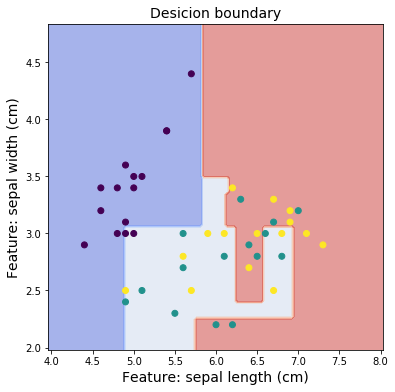

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

plot_desicion_boundary(
    grid_cv, X_test[:, 0], X_test[:, 1], y_test, 
    ax, 'Desicion boundary', df.columns.values[-3], df.columns.values[-2]
)

plt.show()

# Decision trees over-fitting 

## Introduction
Decision trees could easily got over-fitted. 

**Example**: tree in which each leaf corresponds to one element in training dataset. 
It would give 100% accuracy on train dataset, but in the same time bad results on test dataset.

On the picture below, decision boundary is much more complicated for tree with **big numbers of leafs** - tries perform classification in ares, when there is no need (little red squared in white area).

Accuracy DTC (max_leaf=5  ): Train: 0.848 Test: 0.711
Accuracy DTC (max_leaf=106): Train: 0.933 Test: 0.667


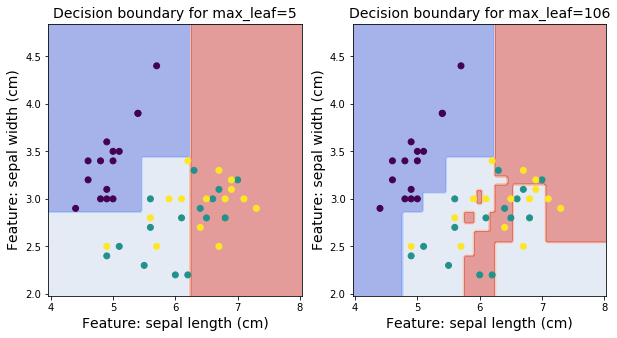

In [18]:
max_leaf_nodes_list = [5, y_train.shape[0] + 1]
clfs = [DTC(max_leaf_nodes=i, random_state=1) for i in max_leaf_nodes_list]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for ID, clf in enumerate(clfs):
    clf.fit(X_train, y_train)
    plot_desicion_boundary(
        clf, X_test[:, 0], X_test[:, 1], y_test, ax[ID],
        'Decision boundary for max_leaf={0}'.format(max_leaf_nodes_list[ID]),
        df.columns.values[-3], df.columns.values[-2])

    print(
        'Accuracy DTC (max_leaf={0: <3}): Train: {1:.3f} Test: {2:.3f}'.format(
            max_leaf_nodes_list[ID],
            f1_score(y_train, clf.predict(X_train), average='micro'),
            f1_score(y_test, clf.predict(X_test), average='micro')))

plt.show()

## Decision tree construction

[Decision tree](https://scikit-learn.org/stable/modules/tree.html)

Key idea - the decision tree is building **greedy**:
1. Take single feature $x_{i}$ from $X$
2. Choose threshold which minimizes loss function:
$$
    Loss =
    \frac{X_{l}}{X_{m}}\times H(X_{l}) +
    \frac{X_{r}}{X_{m}}\times H(X_{r}) 
$$
where: 
    * $X_{l}$ - number of objects in the *left* sub-tree,
    * $X_{r}$ - number of objects in the *right* sub-tree,
    * $X_{m}$ - number of objects in current tree node, which is splitting on *left* and *right* sub-trees,
    * $H(x)$  - informative criterion (dispersion for regression, *Ginny* or *entropy* for classification).
3. Split objects in current node in two parts:
    * Left sub-tree: objects, for which: $x_{i} < threshold$
    * Right sub-tree: objects, for which: $x_{i} >= threshold$



In [33]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import f1_score

# ---- Libraries for Graph visualization

import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image

## Impurity criteria

- *Ginny* - maximum number of objects from the same class will be in one leaf.
- 

In [70]:
def gini(n_samples : int, proportions : list) -> float:
    return 1. - np.sum( (np.array(proportions, dtype=float) / n_samples)**2)

In [108]:
data = load_iris()
X = data.data 
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1
)

dtc = DTC(max_depth=4, criterion='gini', random_state=1)
dtc.fit(X_train, y_train)
print('F1 micro = {0:.3f}'.format(f1_score(y_test, dtc.predict(X_test), average='micro')))

F1 micro = 0.978


In [115]:

def calc_proportion(feature, target, mask, unique):
    split = np.zeros(unique.shape[0])
    for ID, class_ in enumerate(unique):
        split[ID] = np.sum(target[mask] == class_)
    return split

def split(feature, target, thresh):
    unique_classes = np.unique(y)
    left_mask  = feature <= thresh
    right_mask = feature > thresh
    
    return (
        left_mask, right_mask,
        calc_proportion(feature, target, left_mask, unique_classes),
        calc_proportion(feature, target, right_mask, unique_classes)
    )

In [119]:
print(gini(y_train.shape[0], [35, 35, 35]))

lm, rm, lp, rp = split(X_train[:, 3], y_train, 0.75)
print(lp, rp)
print(gini(np.sum(lp), lp))
print(gini(np.sum(rp), rp))

lm1, rm1, lp1, rp1 = split(X_train[rm, 2], y_train[rm], 4.75)
print(lp1, rp1)
print(gini(np.sum(lp1), lp1))
print(gini(np.sum(rp1), rp1))

0.6666666666666667
[35.  0.  0.] [ 0. 35. 35.]
0.0
0.5
[ 0. 30.  0.] [ 0.  5. 35.]
0.0
0.21875


In [128]:
print(gini(y_train.shape[0], [35, 35, 35]))

lm, rm, lp, rp = split(X_train[:, 3], y_train, 0.75)
print(lp, rp)
print(gini(np.sum(lp), lp))
print(gini(np.sum(rp), rp))


unique_feature = np.unique(X_train[rm, 2])
print(unique_feature.shape[0])
for ID, cur in enumerate(unique_feature[:-1]):
    thr = (cur + unique_feature[ID + 1]) / 2.
    lm1, rm1, lp1, rp1 = split(X_train[rm, 2], y_train[rm], thr)
    n_left = np.sum(lp1)
    n_right = np.sum(rp1)
    n_total = n_left + n_right
    
    

    gl = gini(np.sum(lp1), lp1)
    gr = gini(np.sum(rp1), rp1)
    
    print(f'{thr} : {round(n_left*gl/n_total + n_right*gr/n_total, 3)}')

0.6666666666666667
[35.  0.  0.] [ 0. 35. 35.]
0.0
0.5
32
3.4 : 0.493
3.55 : 0.478
3.6500000000000004 : 0.47
3.75 : 0.462
3.8499999999999996 : 0.453
3.95 : 0.426
4.05 : 0.407
4.15 : 0.375
4.25 : 0.34
4.35 : 0.327
4.45 : 0.3
4.55 : 0.222
4.65 : 0.186
4.75 : 0.125
4.85 : 0.156
4.95 : 0.132
5.05 : 0.152
5.15 : 0.222
5.25 : 0.239
5.35 : 0.255
5.45 : 0.271
5.55 : 0.3
5.65 : 0.375
5.75 : 0.386
5.85 : 0.407
5.95 : 0.417
6.05 : 0.435
6.25 : 0.462
6.5 : 0.47
6.65 : 0.478
6.800000000000001 : 0.493


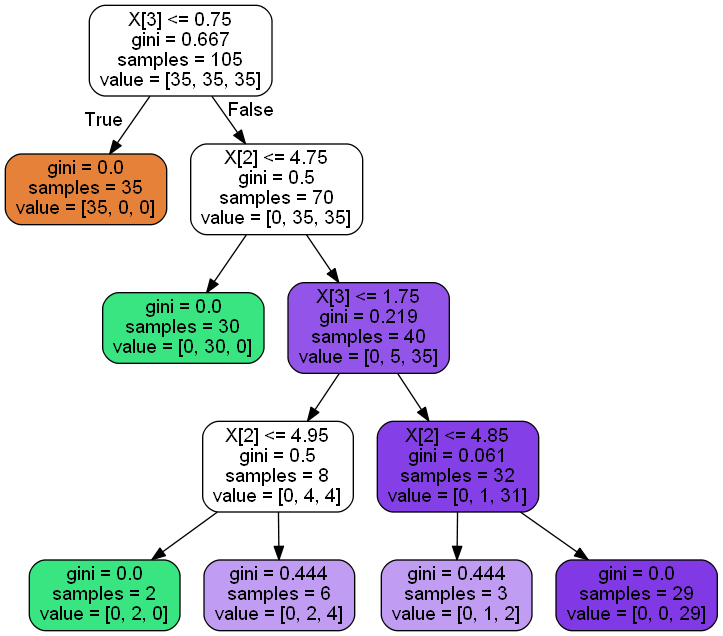

In [110]:
dot_data = StringIO()
tree.export_graphviz(dtc, out_file=dot_data,
#                      class_names=data.target_names, 
#                      feature_names=data.feature_names, 
                     filled=True, rounded=True, label='all'
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

P.S.

To install `graphviz` on windows please:
1. Download `.msi` file [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html)
2. Go to `Control Panel` to add path `C:\Program Files (x86)\Graphviz2.38\bin` to the `PATH` variable.

## Over-fitting

To avoid over-fitting it is necessary to somehow restrict tree's depth.
There are several **stop criteria**:
1. Stop build the tree when objects in a leaf corresponds to one class.
2. Node has exactly K objects `min_samples_leaf`.
3. Tree depth is less or equal than `max_depth`.
4. Restrict number of features, used for learning `max_features`. Better to use `sqrt` value.
5. [Cut random forest](https://freecontent.manning.com/the-randomcutforest-algorithm/) algorithm - we build tree with maximum depth firstly, after that we go from bottom to top, comparing quality of tree with and without this node (check using cross validation).

Let us see how does the tree depth influence on prediction accuracy.